In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers import LeakyReLU
from keras.optimizers import Adam

In [13]:
# 데이토 로드하기
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (600000, 784)
    # 784 columns per row
    x_train = x_train.reshape(60000,784)
    return (x_train, y_train, x_test, y_test)

# 커스텀 아담 옵티마이저
def adam_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

# generator 모델 생성
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

# discriminator 모델 생성
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=1024, input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

# GAN 생성하기
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

# 생성된 이미지 시각화
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)
    
# 학습 함수 정의
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    ## structure of model
    from keras.utils import plot_model
    plot_model(generator, show_shapes=True, to_file='generator.png')
    
    plot_model(discriminator, show_shapes=True, to_file='discriminator.png')
    
    plot_model(gan, show_shapes=True, to_file='gan.png')
    
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        # Generate random noise as an input to initialize the generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            # Construct different batches of real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            # Pretrain discriminator on  fake and real data before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            # Tricking the noised input of the Generator as real data
            y_gen = np.ones(batch_size)
            
            # During the training of gan, the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            # Training  the GAN by alternating the training of the Discriminator and training the chained GAN model with Discriminator's weights freezed.
            gan.train_on_batch(noise, y_gen)
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:01<03:48,  1.80s/it]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:01<01:44,  1.20it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:02<01:04,  1.93it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:02<00:46,  2.66it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:02<00:36,  3.36it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:02<00:30,  3.98it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:02<00:26,  4.56it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:02<00:23,  5.03it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 9/128 [00:03<00:22,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:03<00:20,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:03<00:19,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:03<00:19,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:03<00:18,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:03<00:18,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:03<00:17,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:04<00:17,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:04<00:17,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:04<00:16,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:04<00:16,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:04<00:16,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:04<00:16,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:05<00:16,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:05<00:15,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:05<00:15,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:05<00:15,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:05<00:15,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:05<00:15,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:05<00:15,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:06<00:15,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:06<00:15,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:06<00:15,  6.47it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:06<00:15,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:06<00:15,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:06<00:14,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:07<00:14,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 36/128 [00:07<00:14,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:07<00:14,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 38/128 [00:07<00:14,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:07<00:14,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:07<00:14,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 41/128 [00:08<00:15,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:08<00:14,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 43/128 [00:08<00:14,  5.82it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 44/128 [00:08<00:14,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:08<00:14,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:08<00:13,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:09<00:13,  5.99it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 48/128 [00:09<00:13,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:09<00:12,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:09<00:12,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:09<00:12,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:09<00:12,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 53/128 [00:10<00:11,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:10<00:11,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:10<00:11,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:10<00:11,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:10<00:11,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:10<00:11,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:11<00:11,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:11<00:10,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 61/128 [00:11<00:10,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:11<00:10,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:11<00:10,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:11<00:10,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:12<00:10,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:12<00:10,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:12<00:09,  6.11it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:12<00:10,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:12<00:09,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:12<00:09,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:12<00:09,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:13<00:09,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:13<00:08,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:13<00:08,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:13<00:08,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:13<00:08,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:13<00:08,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:14<00:08,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:14<00:08,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:14<00:07,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  6.02it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▍   | 82/128 [00:14<00:07,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:14<00:07,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:15<00:07,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 85/128 [00:15<00:07,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:15<00:07,  5.73it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:15<00:07,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:15<00:06,  5.82it/s]

4/4 [==============================] - 0s 6ms/step


 70%|██████▉   | 89/128 [00:16<00:06,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:16<00:06,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:16<00:06,  5.78it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 92/128 [00:16<00:06,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:16<00:06,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:16<00:06,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:17<00:05,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:17<00:05,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 100/128 [00:17<00:04,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:18<00:04,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:18<00:03,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:18<00:03,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  6.04it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.89it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 110/128 [00:19<00:03,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:19<00:02,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 112/128 [00:19<00:02,  6.05it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:20<00:02,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:21<00:01,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:21<00:00,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  6.04it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:22<00:00,  5.65it/s]


4/4 [==============================] - 0s 4ms/step


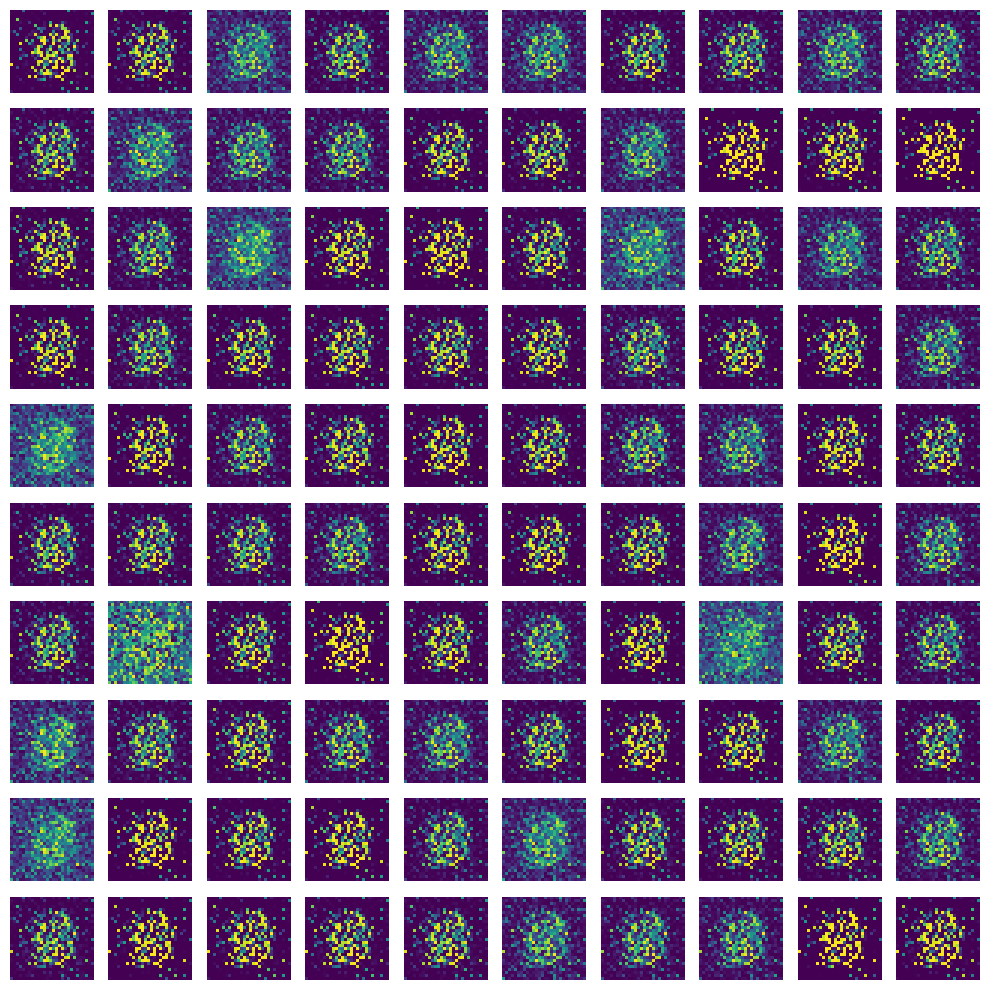

In [14]:
training(1,128)